In [276]:
import numpy as np
import pandas as pd
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import tqdm.notebook as tq
import os
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jasee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [277]:
df = pd.read_csv(r'data\Reviews.csv')

In [278]:
df = df.dropna()

In [279]:
def convert(x):
    if x>3:
        return 2
    elif x<3:
        return 0
    elif x==3:
        return 1
df['Score'] = df['Score'].map(convert)

In [280]:
X = df['Text']
y = df['Score']

In [281]:
X = X.reset_index()

In [282]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X, y)

undersample = RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_under, y_under)

In [283]:
y_under_plot = to_categorical(y_under, num_classes=3)

In [284]:
y = np.array(y_under)

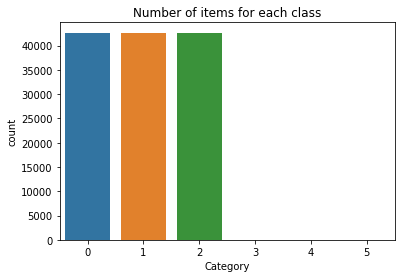

In [285]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(6,4))
    g = sns.countplot(ydf[0], order = np.arange(0,6))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    plt.show()  
    
plot_count_per_class(np.argmax(y_under_plot,axis=1))

In [286]:
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        text= BeautifulSoup(text,'lxml').getText()
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
X_under['Text'] = normalize_texts(X_under['Text'])

In [287]:
X_under['Text']

0         why is this coffee tagged as whole bean   amaz...
1         didnt help with the smell of my dog at all lef...
2         i know allowances need to be made for being gl...
3         i didn t like the taste of this at all  i trie...
4         how shall i put this     yuck   i guess i m sp...
                                ...                        
127909    oh  snap  that s right  alec baldwin once upon...
127910    i love these healthy dog treats  my dog has tr...
127911    my first experience with dr  mcdougall s produ...
127912    the first time i try  ginger tree  ginger ale ...
127913    the blend of flavor is fantastic for this oliv...
Name: Text, Length: 127914, dtype: object

In [289]:
%%time
from nltk.stem import PorterStemmer
X_under['Text'] = X_under['Text'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split() if word not in stopwords.words('english')]))

Wall time: 1h 18min 44s


In [290]:
%%time
X_under['Text']

Wall time: 0 ns


0         coffe tag whole bean amazon classifi whole bea...
1         didnt help smell dog left white even brush plu...
2         know allow need made gluten free sinc hard get...
3         like tast tri stevia packet like thought would...
4         shall put yuck guess spoil local roaster thoug...
                                ...                        
127909    oh snap right alec baldwin upon time svelt doc...
127910    love healthi dog treat dog troubl lot process ...
127911    first experi dr mcdougal product like vegan bl...
127912    first time tri ginger tree ginger ale casino l...
127913    blend flavor fantast oliv oil season bread dip...
Name: Text, Length: 127914, dtype: object

In [425]:
X_train, X_val, y_train, y_val = train_test_split(X_under['Text'], y, test_size = 0.2, random_state = 42)

In [426]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=6000)
tfidf_model.fit(X_train, y_train)
X_train_tfidf = tfidf_model.transform(X_train)
X_val_tfidf = tfidf_model.transform(X_val)

In [427]:
print(X_train_tfidf.shape)

(102331, 6000)


In [418]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

In [419]:
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [420]:
y_pred = model.predict(X_val_tfidf)

In [421]:
print(y_pred)

[0 2 1 ... 1 1 1]


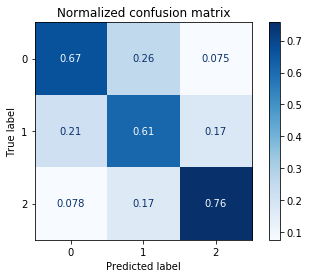

In [422]:
titles_options = [("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_val_tfidf, y_val,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)

plt.show()

In [423]:
accuracy_score(y_val,y_pred)

0.6787054409005628

In [424]:
with open('nbWithtfidf', 'wb') as fout:
    pickle.dump((tfidf_model, model), fout)